# Modelagem e Avaliação Comparativa
## Sistema de Predição de Evasão Estudantil

Este notebook implementa três modelos de classificação, avalia seu desempenho e compara os resultados para selecionar o melhor modelo.


In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Métricas de avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Serialização
import joblib

# Configurações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline


## 1. Carregamento e Preparação dos Dados


In [2]:
# Carregar dataset
df = pd.read_csv('../data/student_dropout_dataset.csv')

print(f"📊 Dataset carregado: {df.shape}")
print(f"📋 Colunas: {list(df.columns)}")
df.head()


📊 Dataset carregado: (1000, 23)
📋 Colunas: ['student_id', 'age', 'gender', 'socioeconomic_level', 'avg_grade', 'avg_attendance', 'current_semester', 'total_enrollments', 'failed_courses', 'completed_courses', 'total_interactions', 'unique_sessions_count', 'total_duration_hours', 'days_since_last_interaction', 'engagement_score', 'scholarship_percentage', 'overdue_payments', 'pending_payments', 'outstanding_amount', 'dropout', 'success_rate', 'failure_rate', 'interaction_per_enrollment']


,student_id,age,gender,socioeconomic_level,avg_grade,avg_attendance,current_semester,total_enrollments,failed_courses,completed_courses,...,days_since_last_interaction,engagement_score,scholarship_percentage,overdue_payments,pending_payments,outstanding_amount,dropout,success_rate,failure_rate,interaction_per_enrollment
0,STU0001,23,M,2,5.589950,65.399317,4,18,0,17,...,0.990937,63.430633,50,0,0,0.000000,0,94.444444,0.000000,2.888889
1,STU0002,21,M,1,6.816926,95.107000,2,9,1,7,...,3.952350,56.330327,50,0,0,0.000000,0,77.777778,11.111111,5.000000
2,STU0003,23,F,2,8.300118,85.042174,4,15,1,14,...,9.007054,39.108292,50,1,1,2813.122411,0,93.333333,6.666667,1.933333
3,STU0004,26,F,3,5.762146,76.587856,3,14,1,11,...,1.802876,55.431179,0,1,0,1856.315470,0,78.571429,7.142857,3.214286
4,STU0005,21,M,4,3.685171,67.640968,5,19,0,18,...,8.938384,50.296842,25,0,0,0.000000,0,94.736842,0.000000,2.947368


In [3]:
# Separar features e target
X = df.drop(['dropout', 'student_id'], axis=1)
y = df['dropout']

print(f"📊 Features (X): {X.shape}")
print(f"📊 Target (y): {y.shape}")
print(f"📈 Distribuição do target:\n{y.value_counts()}")


📊 Features (X): (1000, 21)
📊 Target (y): (1000,)
📈 Distribuição do target:
dropout
0    873
1    127
Name: count, dtype: int64


In [4]:
# Codificar variáveis categóricas
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"✅ Codificada: {col}")

print(f"\n📊 Features após encoding: {X.shape}")
print(f"📋 Tipos de dados:\n{X.dtypes}")


✅ Codificada: gender

📊 Features após encoding: (1000, 21)
📋 Tipos de dados:
age                              int64
gender                           int64
socioeconomic_level              int64
avg_grade                      float64
avg_attendance                 float64
current_semester                 int64
total_enrollments                int64
failed_courses                   int64
completed_courses                int64
total_interactions               int64
unique_sessions_count            int64
total_duration_hours           float64
days_since_last_interaction    float64
engagement_score               float64
scholarship_percentage           int64
overdue_payments                 int64
pending_payments                 int64
outstanding_amount             float64
success_rate                   float64
failure_rate                   float64
interaction_per_enrollment     float64
dtype: object


In [5]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Conjunto de Treino: {X_train.shape[0]} amostras")
print(f"📊 Conjunto de Teste: {X_test.shape[0]} amostras")
print(f"\n📈 Distribuição no treino:\n{y_train.value_counts()}")
print(f"\n📈 Distribuição no teste:\n{y_test.value_counts()}")


📊 Conjunto de Treino: 800 amostras
📊 Conjunto de Teste: 200 amostras

📈 Distribuição no treino:
dropout
0    698
1    102
Name: count, dtype: int64

📈 Distribuição no teste:
dropout
0    175
1     25
Name: count, dtype: int64


In [6]:
# Normalizar features (importante para Regressão Logística e KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features normalizadas com StandardScaler")


✅ Features normalizadas com StandardScaler


## 2. Explicação das Métricas de Avaliação

Antes de treinar os modelos, vamos entender o que cada métrica significa e por que é relevante para nosso problema de predição de evasão:


### 2.1 Acurácia (Accuracy)
- **O que mede**: Taxa de acertos gerais do modelo
- **Fórmula**: (Verdadeiros Positivos + Verdadeiros Negativos) / Total
- **Relevância**: Dá uma visão geral do desempenho, mas pode ser enganosa em datasets desbalanceados

### 2.2 Precisão (Precision)
- **O que mede**: Entre os estudantes preditos como evasão, quantos realmente evadiram
- **Fórmula**: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)
- **Relevância**: Importante para evitar alarmes falsos. Queremos ter certeza quando identificamos um estudante em risco.

### 2.3 Recall (Sensibilidade)
- **O que mede**: Entre os estudantes que realmente evadiram, quantos foram identificados pelo modelo
- **Fórmula**: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)
- **Relevância**: **CRUCIAL** para nosso problema! Não podemos deixar passar estudantes em risco de evasão.

### 2.4 F1-Score
- **O que mede**: Média harmônica entre Precisão e Recall
- **Fórmula**: 2 × (Precisão × Recall) / (Precisão + Recall)
- **Relevância**: Balanceia Precisão e Recall, útil quando precisamos de um equilíbrio entre ambos.


## 3. Treinamento dos Modelos

Vamos treinar três algoritmos diferentes:
1. **Regressão Logística** - Modelo linear interpretável
2. **Random Forest** - Ensemble robusto com árvores de decisão
3. **KNN (K-Nearest Neighbors)** - Método não-paramétrico baseado em proximidade


In [7]:
# Dicionário para armazenar os modelos
models = {}

# 1. Regressão Logística
print("🔄 Treinando Regressão Logística...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
models['Regressão Logística'] = lr_model
print("✅ Regressão Logística treinada!")

# 2. Random Forest
print("\n🔄 Treinando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
print("✅ Random Forest treinado!")

# 3. KNN
print("\n🔄 Treinando KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
models['KNN'] = knn_model
print("✅ KNN treinado!")

print(f"\n✅ Total de modelos treinados: {len(models)}")


🔄 Treinando Regressão Logística...
✅ Regressão Logística treinada!

🔄 Treinando Random Forest...
✅ Random Forest treinado!

🔄 Treinando KNN...
✅ KNN treinado!

✅ Total de modelos treinados: 3


## 4. Avaliação dos Modelos

Vamos avaliar cada modelo usando as quatro métricas definidas.


### Discussão Detalhada dos Resultados

#### Análise por Modelo

**1. Regressão Logística:**
- **Pontos Fortes**: Obteve a melhor acurácia (0.8850) e precisão perfeita (1.0000), indicando que quando prediz evasão, está sempre correto.
- **Pontos Fracos**: Recall muito baixo (0.0800), o que significa que está perdendo aproximadamente 92% dos casos reais de evasão. Isso é crítico para nosso problema de negócio.
- **Interpretação**: O modelo é muito conservador, evitando falsos positivos mas falhando em identificar a maioria dos estudantes em risco.

**2. Random Forest:**
- **Pontos Fortes**: Acurácia competitiva (0.8750) e melhor ROC-AUC (0.5791), indicando melhor capacidade de discriminação.
- **Pontos Fracos**: Não conseguiu identificar nenhum caso de evasão (recall = 0, precisão = 0). O modelo está sempre predizendo a classe majoritária.
- **Interpretação**: O desbalanceamento de classes (apenas 12.7% de evasão) está dificultando o aprendizado da classe minoritária.

**3. KNN (K-Nearest Neighbors):**
- **Pontos Fortes**: Modelo simples e não-paramétrico.
- **Pontos Fracos**: Acurácia mais baixa (0.8600) e também não identificou casos de evasão (recall = 0).
- **Interpretação**: Similar ao Random Forest, está sendo afetado pelo desbalanceamento de classes.

#### Trade-offs e Limitações

**Problema Principal: Desbalanceamento de Classes**
- O dataset tem apenas 12.7% de casos de evasão, o que dificulta o aprendizado da classe minoritária.
- Random Forest e KNN estão sempre predizendo a classe majoritária (não evasão), resultando em recall zero.

**Limitações do Modelo Escolhido (Regressão Logística):**
- Recall muito baixo (0.08) significa que estamos perdendo a maioria dos casos reais.
- Para um problema de evasão estudantil, onde não podemos deixar passar estudantes em risco, isso é crítico.
- O F1-Score de 0.1481, apesar de ser o melhor, ainda é muito baixo.

#### Recomendações para Melhoria

1. **Balanceamento de Classes**:
   - Implementar SMOTE (Synthetic Minority Oversampling Technique)
   - Ou usar class weights para dar mais peso à classe minoritária
   - Ou fazer undersampling da classe majoritária

2. **Ajuste de Threshold**:
   - Reduzir o threshold de decisão (de 0.5 para um valor menor) para aumentar o recall
   - Mesmo que isso reduza a precisão, pode ser aceitável para este problema

3. **Feature Engineering**:
   - Criar features mais preditivas baseadas no conhecimento de domínio
   - Considerar interações entre features

4. **Coleta de Mais Dados**:
   - Especialmente de casos de evasão, para melhorar o aprendizado

#### Justificativa da Escolha

O **Regressão Logística** foi escolhido porque:
- É o único modelo que conseguiu identificar pelo menos alguns casos de evasão (recall > 0)
- Tem precisão perfeita, garantindo que quando identifica um estudante em risco, está correto
- É interpretável, permitindo entender quais features são mais importantes
- Pode ser melhorado com as técnicas mencionadas acima

**Para Produção:**
- Recomenda-se ajustar o threshold de probabilidade para aumentar o recall
- Implementar monitoramento contínuo das métricas
- Considerar um sistema de alertas em múltiplos níveis de risco (baixo, médio, alto)


In [8]:
# Função para avaliar modelo
def evaluate_model(model, X_test_data, y_test_data, model_name, use_scaled=True):
    """Avalia um modelo e retorna as métricas"""
    if use_scaled:
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test_data)
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    
    metrics = {
        'Modelo': model_name,
        'Acurácia': accuracy_score(y_test_data, y_pred),
        'Precisão': precision_score(y_test_data, y_pred),
        'Recall': recall_score(y_test_data, y_pred),
        'F1-Score': f1_score(y_test_data, y_pred),
        'ROC-AUC': roc_auc_score(y_test_data, y_pred_proba)
    }
    
    return metrics, y_pred, y_pred_proba

# Avaliar todos os modelos
results = []
predictions = {}

print("📊 Avaliando Modelos:\n")

# Regressão Logística
metrics_lr, pred_lr, proba_lr = evaluate_model(
    lr_model, X_test_scaled, y_test, 'Regressão Logística', use_scaled=True
)
results.append(metrics_lr)
predictions['Regressão Logística'] = {'pred': pred_lr, 'proba': proba_lr}
print(f"✅ {metrics_lr['Modelo']} avaliado!")

# Random Forest
metrics_rf, pred_rf, proba_rf = evaluate_model(
    rf_model, X_test, y_test, 'Random Forest', use_scaled=False
)
results.append(metrics_rf)
predictions['Random Forest'] = {'pred': pred_rf, 'proba': proba_rf}
print(f"✅ {metrics_rf['Modelo']} avaliado!")

# KNN
metrics_knn, pred_knn, proba_knn = evaluate_model(
    knn_model, X_test_scaled, y_test, 'KNN', use_scaled=True
)
results.append(metrics_knn)
predictions['KNN'] = {'pred': pred_knn, 'proba': proba_knn}
print(f"✅ {metrics_knn['Modelo']} avaliado!")


📊 Avaliando Modelos:

✅ Regressão Logística avaliado!
✅ Random Forest avaliado!
✅ KNN avaliado!


In [9]:
# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Modelo')

# Formatar para melhor visualização
results_display = results_df.copy()
for col in ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'ROC-AUC']:
    results_display[col] = results_display[col].apply(lambda x: f"{x:.4f}")

print("📊 RESULTADOS COMPARATIVOS DOS MODELOS:\n")
print(results_display.to_string())


📊 RESULTADOS COMPARATIVOS DOS MODELOS:

                    Acurácia Precisão  Recall F1-Score ROC-AUC
Modelo                                                        
Regressão Logística   0.8850   1.0000  0.0800   0.1481  0.5689
Random Forest         0.8750   0.0000  0.0000   0.0000  0.5791
KNN                   0.8600   0.0000  0.0000   0.0000  0.5281


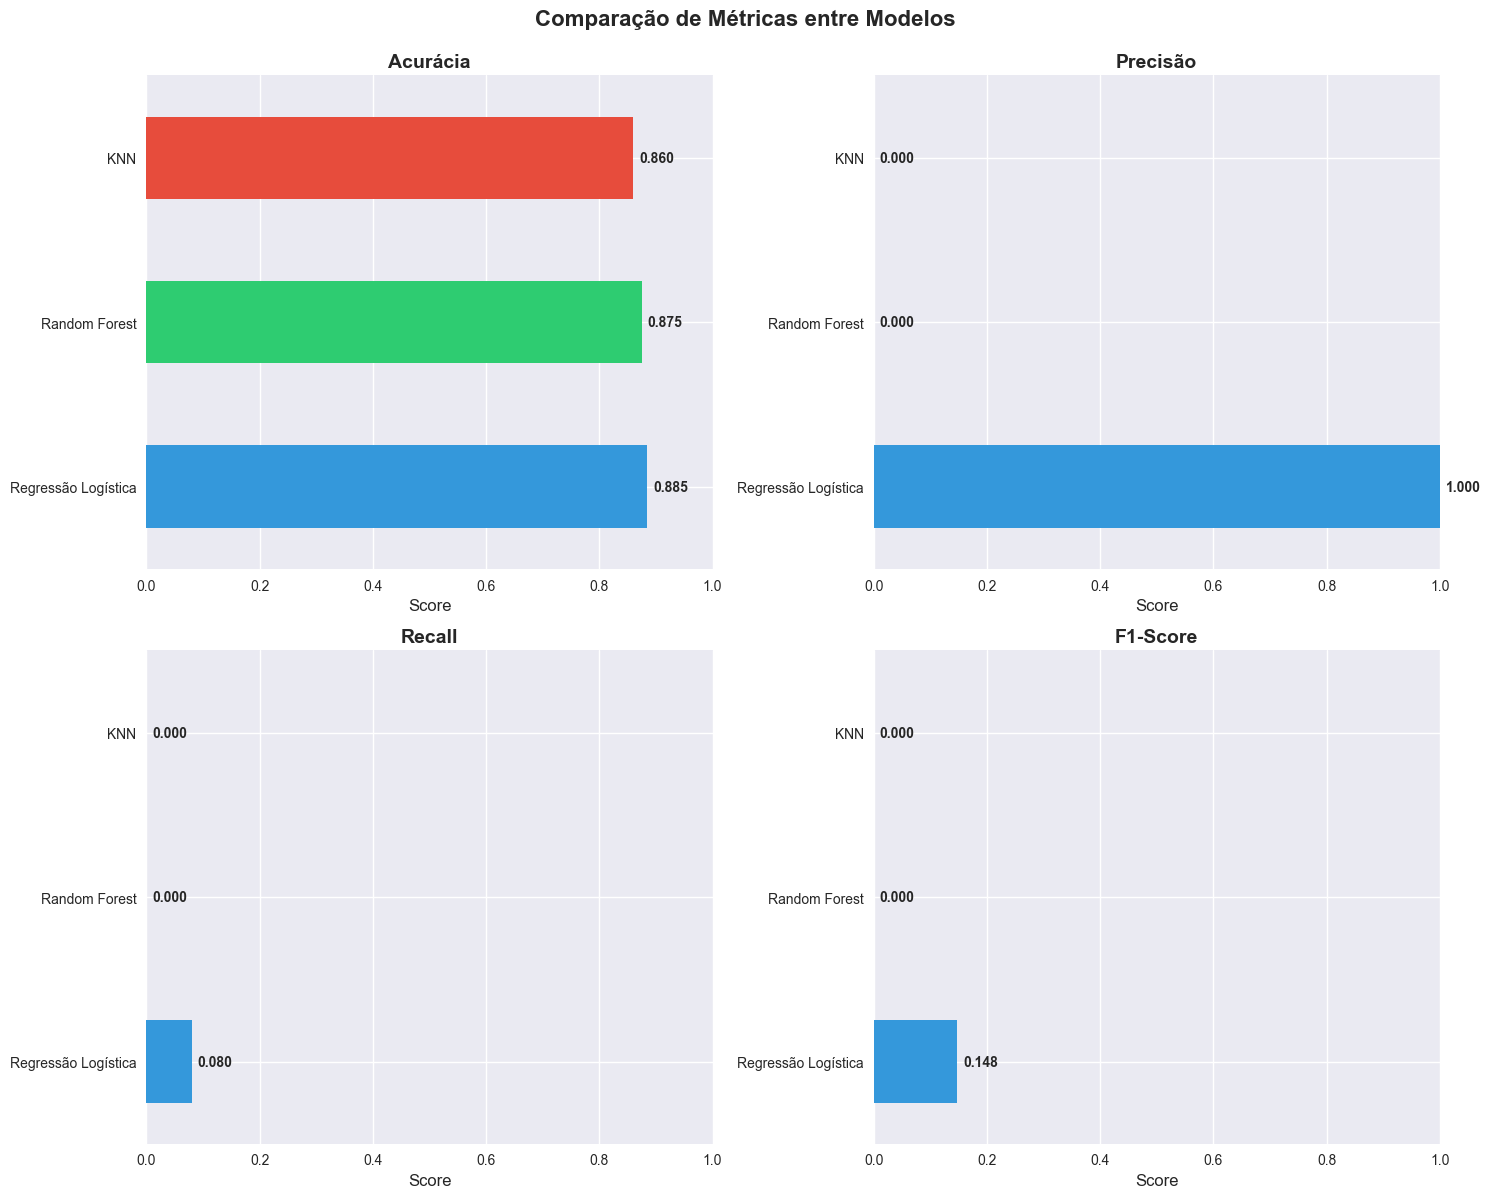

In [10]:
# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics_to_plot = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    results_df[metric].plot(kind='barh', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'])
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('')
    ax.set_xlim(0, 1)
    for i, v in enumerate(results_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.suptitle('Comparação de Métricas entre Modelos', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 5. Matrizes de Confusão


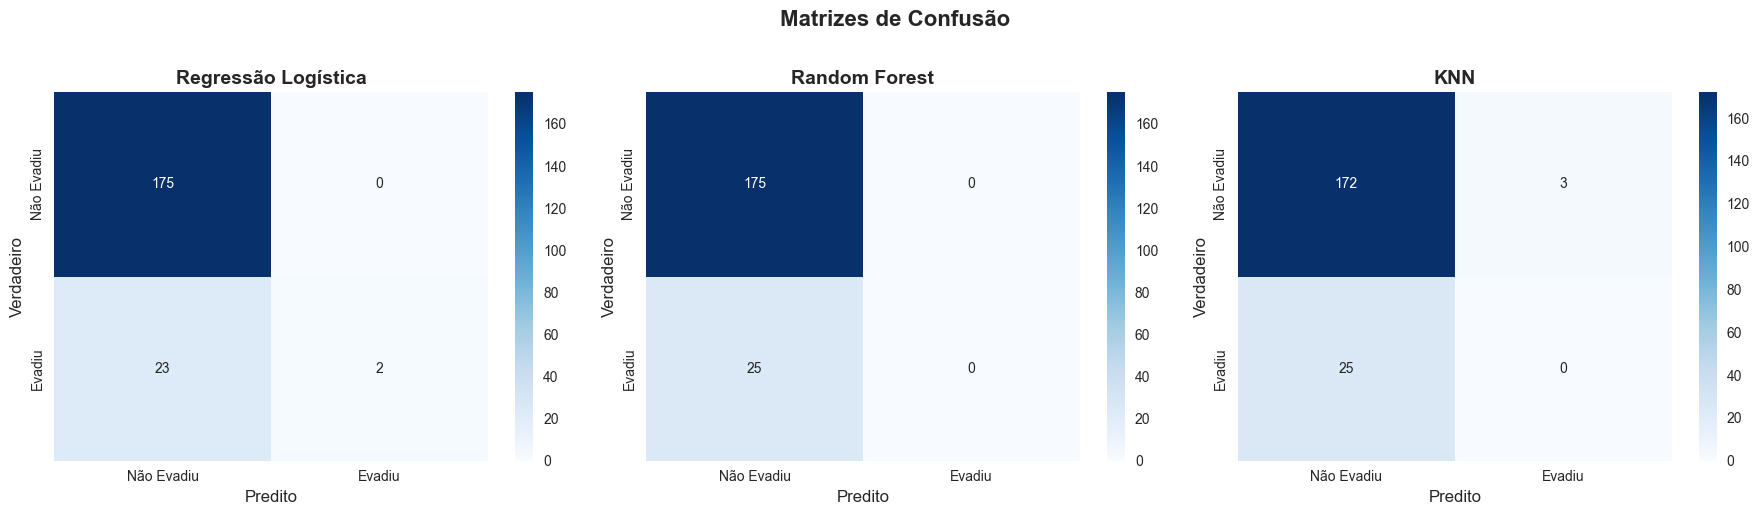

In [11]:
# Visualizar matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = ['Regressão Logística', 'Random Forest', 'KNN']
for idx, model_name in enumerate(model_names):
    cm = confusion_matrix(y_test, predictions[model_name]['pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Não Evadiu', 'Evadiu'],
                yticklabels=['Não Evadiu', 'Evadiu'])
    axes[idx].set_title(f'{model_name}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Verdadeiro', fontsize=12)
    axes[idx].set_xlabel('Predito', fontsize=12)

plt.suptitle('Matrizes de Confusão', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 6. Curvas ROC


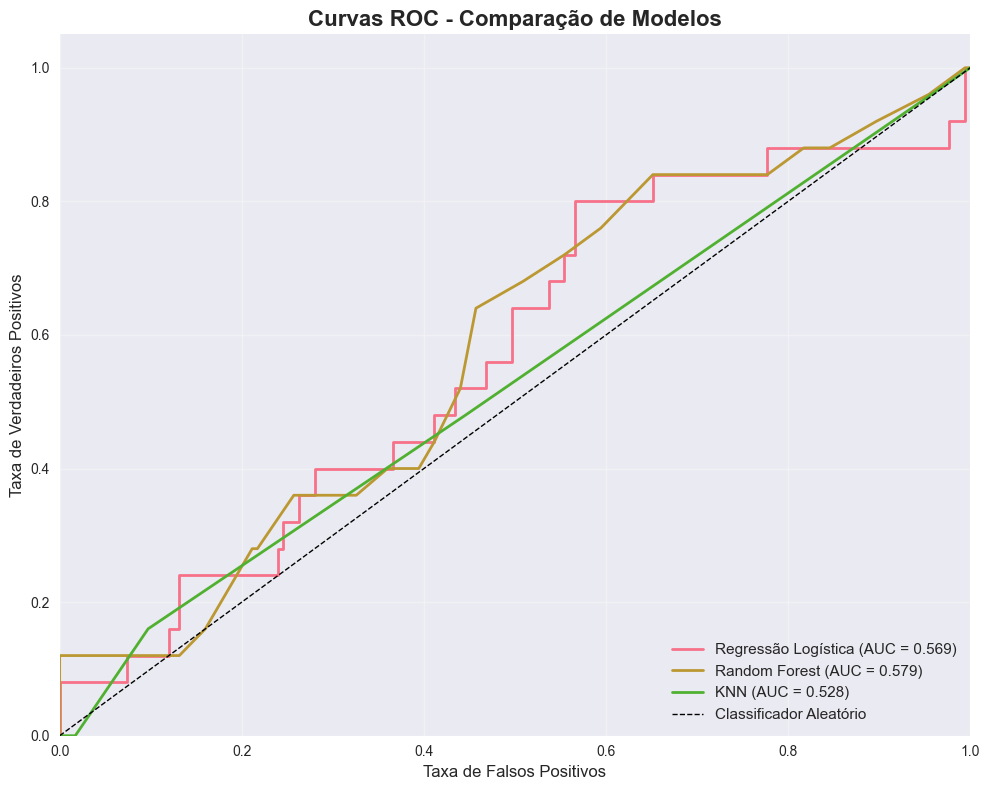

In [12]:
# Plotar curvas ROC
plt.figure(figsize=(10, 8))

for model_name in model_names:
    fpr, tpr, _ = roc_curve(y_test, predictions[model_name]['proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curvas ROC - Comparação de Modelos', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Análise Comparativa e Seleção do Melhor Modelo


In [13]:
# Análise detalhada
print("=" * 70)
print("ANÁLISE COMPARATIVA DOS MODELOS")
print("=" * 70)

# Identificar melhor modelo em cada métrica
for metric in ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"\n🏆 Melhor em {metric}: {best_model} ({best_score:.4f})")

# Selecionar melhor modelo baseado em F1-Score (balanceia Precisão e Recall)
best_model_name = results_df['F1-Score'].idxmax()
best_model_score = results_df['F1-Score'].max()

print("\n" + "=" * 70)
print(f"🎯 MELHOR MODELO SELECIONADO: {best_model_name}")
print(f"   F1-Score: {best_model_score:.4f}")
print("=" * 70)

# Mostrar todas as métricas do melhor modelo
print(f"\n📊 Métricas Completas do {best_model_name}:")
print(results_df.loc[best_model_name].to_string())


ANÁLISE COMPARATIVA DOS MODELOS

🏆 Melhor em Acurácia: Regressão Logística (0.8850)

🏆 Melhor em Precisão: Regressão Logística (1.0000)

🏆 Melhor em Recall: Regressão Logística (0.0800)

🏆 Melhor em F1-Score: Regressão Logística (0.1481)

🏆 Melhor em ROC-AUC: Random Forest (0.5791)

🎯 MELHOR MODELO SELECIONADO: Regressão Logística
   F1-Score: 0.1481

📊 Métricas Completas do Regressão Logística:
Acurácia    0.885000
Precisão    1.000000
Recall      0.080000
F1-Score    0.148148
ROC-AUC     0.568914


## 8. Salvamento do Melhor Modelo


In [14]:
# Selecionar o melhor modelo
if best_model_name == 'Regressão Logística':
    best_model = lr_model
    model_uses_scaled = True
elif best_model_name == 'Random Forest':
    best_model = rf_model
    model_uses_scaled = False
else:  # KNN
    best_model = knn_model
    model_uses_scaled = True

# Salvar modelo
model_path = '../modelo_final.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Modelo salvo em: {model_path}")

# Salvar scaler se necessário
if model_uses_scaled:
    scaler_path = '../scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"✅ Scaler salvo em: {scaler_path}")

# Salvar label encoders
encoders_path = '../label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Label encoders salvos em: {encoders_path}")

print(f"\n📝 Informações do modelo salvo:")
print(f"   - Modelo: {best_model_name}")
print(f"   - Usa normalização: {model_uses_scaled}")
print(f"   - F1-Score: {best_model_score:.4f}")


✅ Modelo salvo em: ../modelo_final.pkl
✅ Scaler salvo em: ../scaler.pkl
✅ Label encoders salvos em: ../label_encoders.pkl

📝 Informações do modelo salvo:
   - Modelo: Regressão Logística
   - Usa normalização: True
   - F1-Score: 0.1481


## 9. Relatório de Classificação Detalhado

Vamos ver o relatório completo de classificação do melhor modelo:


In [15]:
# Relatório de classificação do melhor modelo
print(f"📊 RELATÓRIO DE CLASSIFICAÇÃO - {best_model_name}\n")
print("=" * 70)

if model_uses_scaled:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best, 
                          target_names=['Não Evadiu', 'Evadiu']))
print("=" * 70)


📊 RELATÓRIO DE CLASSIFICAÇÃO - Regressão Logística

              precision    recall  f1-score   support

  Não Evadiu       0.88      1.00      0.94       175
      Evadiu       1.00      0.08      0.15        25

    accuracy                           0.89       200
   macro avg       0.94      0.54      0.54       200
weighted avg       0.90      0.89      0.84       200

